# Library

In [53]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
tf.keras.utils.image_dataset_from_directory
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from tensorflow.keras.models import load_model

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

%matplotlib inline

# Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Project Capstone

/content/drive/MyDrive/Project Capstone


In [3]:
#dataset_path = '/content/drive/MyDrive/Project Capstone/new_dataset'

In [47]:
class_names = ['Symbolism','Expressionism','Academic','Rococo','Romanticism','Western Medieval','Realism','Primitivism','Renaissance','Baroque','Japanese','Nouveau','Neoclassicism']

In [58]:
print(type(class_names))

<class 'list'>


In [7]:
import os
import random
import shutil

In [39]:
splitted_dataset_dir = "/content/drive/MyDrive/Project Capstone/Fadhil's Lab/splitted_dataset/"

In [21]:
train_dir = "/content/drive/MyDrive/Project Capstone/Fadhil's Lab/splitted_dataset/train"
val_dir   = "/content/drive/MyDrive/Project Capstone/Fadhil's Lab/splitted_dataset/val"

In [62]:
file_list = os.listdir(train_dir)
for image_class in file_list:
    print(image_class)

Symbolism
Expressionism
Academic
Rococo
Romanticism
Western Medieval
Realism
Primitivism
Renaissance
Baroque
Japanese
Nouveau
Neoclassicism


In [32]:
def list_images(folder_path):
    image_extensions = ['.jpg', '.jpeg', '.png']  # Specify the image file extensions you want to consider
    image_files = []
    
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in image_extensions:
                image_files.append(os.path.join(root, file))
    
    return image_files

In [ ]:
#Check image's availability
# Call the function to list the images
image_files = list_images(val_dir)

# Print the list of image files
for image_file in image_files:
    print(image_file)

In [29]:
'''os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)'''

In [28]:
validation_ratio = 0.2

#### Sekali aja run nyaa nichh

In [ ]:
# Iterate through the subdirectories of the original dataset
'''for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        images = os.listdir(class_dir)
        random.shuffle(images)
        num_val_images = int(len(images) * validation_ratio)

        # Move images to the validation directory
        for img_name in images[:num_val_images]:
            src = os.path.join(class_dir, img_name)
            dst = os.path.join(val_dir, class_name, img_name)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.move(src, dst)

        # Move remaining images to the training directory
        for img_name in images[num_val_images:]:
            src = os.path.join(class_dir, img_name)
            dst = os.path.join(train_dir, class_name, img_name)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.move(src, dst)'''

## Preprocessing (under construction)

In [21]:
ImageDataGenerator??

In [35]:
batch_size = 32
img_size = (224,224)

In [36]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    rescale=1./255, 
)   

In [24]:
ImageDataGenerator.flow_from_directory??

In [38]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    seed=42,
    target_size=img_size,
    batch_size=batch_size, 
    shuffle=True,
    color_mode="rgb",
    class_mode="categorical",
    subset='training',
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    seed=42,
    target_size=img_size,
    batch_size=batch_size, 
    shuffle=True,
    color_mode="rgb",
    class_mode="categorical",
    subset='validation',
)

Found 1040 images belonging to 13 classes.
Found 0 images belonging to 13 classes.


# Preprocessing v2

In [50]:
X_train = []
y_train = []
image_size = 224

for i in class_names:
    folderPath = os.path.join(splitted_dataset_dir, 'train', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        if img is not None:  # Check if the image is not empty
            img = cv2.resize(img, (image_size, image_size))
            X_train.append(img)
            y_train.append(i)

for i in class_names:
    folderPath = os.path.join(splitted_dataset_dir, 'val', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        if img is not None:  # Check if the image is not empty
            img = cv2.resize(img, (image_size, image_size))
            X_train.append(img)
            y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)


100%|██████████| 20/20 [00:04<00:00,  4.27it/s]


(1299, 224, 224, 3)

## Splitting The Datast

In [54]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

### Performing One Hot Encoding

In [63]:
import numpy as np
import tensorflow as tf

# Convert one-hot encoded labels to class names for y_train
y_train_new = []
for label in y_train:
    index = np.argmax(label)  # Get the index of the activated class
    y_train_new.append(class_names[index])
y_train = y_train_new

# Convert one-hot encoded labels to class names for y_test
y_test_new = []
for label in y_test:
    index = np.argmax(label)  # Get the index of the activated class
    y_test_new.append(class_names[index])
y_test = y_test_new

# Convert class names to indices for y_train
y_train = [class_names.index(label) for label in y_train]

# Convert class names to indices for y_test
y_test = [class_names.index(label) for label in y_test]

# Convert labels to categorical format
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)


# Model EfficientNetB0 

In [64]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 0s 0us/step


In [67]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(len(class_names),activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [68]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']    

In [69]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [70]:
#tensorboard = TensorBoard(log_dir = 'logs')
#checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

## Train The Model EfficientNetB0

In [72]:
history = model.fit(X_train,y_train,validation_split=0.2, epochs =3, verbose=1, batch_size=32,
                   callbacks=[reduce_lr])

Epoch 1/3
26/26 [==============================] - 290s 11s/step - loss: 1.0548 - accuracy: 0.6811 - val_loss: 1.6040 - val_accuracy: 0.4904 - lr: 0.0010
Epoch 2/3
26/26 [==============================] - 283s 11s/step - loss: 0.4822 - accuracy: 0.8797 - val_loss: 2.0581 - val_accuracy: 0.4567 - lr: 0.0010
Epoch 3/3
26/26 [==============================] - 284s 11s/step - loss: 0.2356 - accuracy: 0.9495 - val_loss: 1.8967 - val_accuracy: 0.5048 - lr: 0.0010


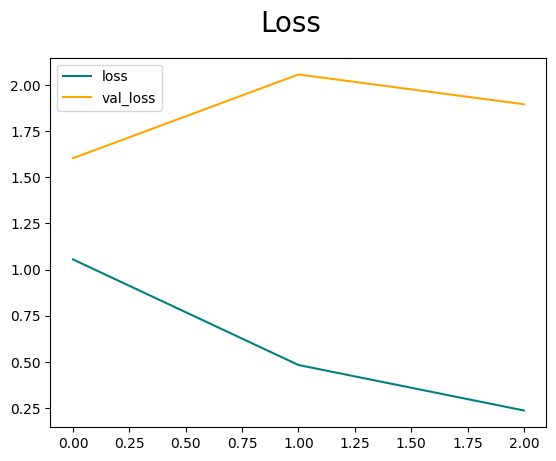

In [77]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

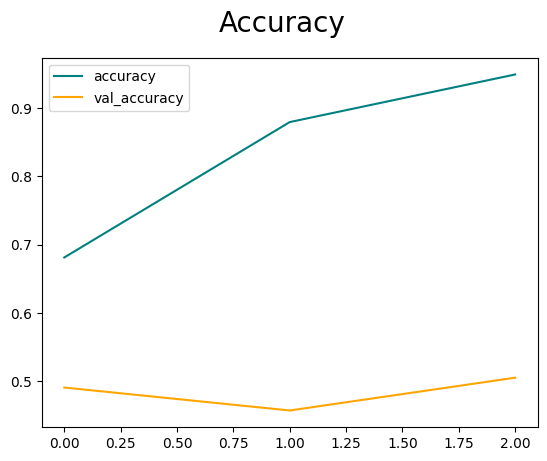

In [78]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Prediction EfficientNetB0 model

In [73]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

9/9 [==============================] - 21s 2s/step


### Eval EfficientNetB0 model